## PUBG recent match statistics
Analysis of the last 14 days of PUBG matches for a given player

In [1]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import os
import shutil
from datetime import datetime

In [2]:
player = 'chocoTaco'

In [3]:
#Destination for saved plots 
destination = os.getcwd()  

In [4]:
def get_match_stats(playername, n):

    with open('API_KEY.txt', 'r') as keyfile:
            api_key = keyfile.read()               

    def get_match_IDS(playername):    #Gets the match IDS for the last 14 days for player specified

            url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+playername          
            header = {
              "Authorization": "Bearer "+api_key,
              "Accept": "application/vnd.api+json"
            }

            response = requests.get(url, headers=header).json()
            matchIDS = [response['data'][0]['relationships']['matches']['data'][i]['id'] for i,_ in enumerate(response['data'][0]['relationships']['matches']['data'])]
            return matchIDS

    def get_match_data(match_ID):    #Gets the match data for the match ID provided
            url = "https://api.pubg.com/shards/steam/matches/"+match_ID       
            header = {
              "Authorization": "Bearer "+api_key,
              "Accept": "application/vnd.api+json"
            }

            response = requests.get(url, headers=header).json()
            
            match_metadata = response['data']['attributes']
            
            participants = [ob for ob in response['included'] if ob['type']=='participant']
            for player in participants:
                if player['attributes']['stats']['name']==playername:
                    match_playerdata = (player['attributes']['stats'])
            
            return match_metadata, match_playerdata  #TO DO :replace 'playerdata' with actual player stats and concat with match metadata
                    

    matchIDS = get_match_IDS(playername)
    if n=='all':
        n=len(matchIDS)
    else:
        n = min(n, len(matchIDS)+1)
    print(f'Fetching match data for {playername} (= {n} matches)')
    matches_metadata=[]
    matches_playerdata=[]
    for match_ID in matchIDS[:n]:
        match_metadata, match_playerdata = get_match_data(match_ID)
        matches_metadata.append(match_metadata)
        matches_playerdata.append(match_playerdata)
    print('done')
    return pd.concat([pd.DataFrame(matches_metadata)[['createdAt', 'gameMode', 'mapName']], pd.DataFrame(matches_playerdata)], axis=1)

In [5]:
match_stats = get_match_stats(player ,'all')

Fetching match data for chocoTaco (= 461 matches)
done


In [6]:
match_stats.head()

,createdAt,gameMode,mapName,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,...,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,winPoints,winPointsDelta
0,2019-01-18T19:34:57Z,solo-fpp,Desert_Main,0,2,9,2117.932620,alive,10,5,...,0,0.0,0,1921.642,0,3651.074460,13,1,0,0
1,2019-01-18T19:27:49Z,solo-fpp,Desert_Main,0,0,0,746.349300,byplayer,2,1,...,0,0.0,0,293.622,0,239.121277,3,68,0,0
2,2019-01-18T19:12:32Z,solo-fpp,Desert_Main,0,0,3,923.076400,suicide,8,1,...,0,0.0,1,782.419,0,2024.325000,4,37,0,0
3,2019-01-18T19:08:10Z,solo-fpp,Desert_Main,0,0,0,259.908264,byplayer,0,0,...,0,0.0,0,101.968,0,15.249277,1,92,0,0
4,2019-01-18T19:02:17Z,solo-fpp,Desert_Main,0,0,0,174.880000,byplayer,1,0,...,0,0.0,0,209.665,0,201.889908,2,82,0,0


In [7]:
def generate_plots(data):
    playername = data['name'].iloc[0]
    earliest= data['createdAt'].min().split('T')[0]
    latest = data['createdAt'].max().split('T')[0]
    
    data=data.drop(['createdAt', 'name', 'playerId', 'killPoints', 'killPointsDelta', 'lastKillPoints', 'lastWinPoints', 'mostDamage', 'rankPoints', 'winPoints', 'winPointsDelta'], axis=1)
    numericals = data[['damageDealt', 'longestKill', 'rideDistance', 'swimDistance', 'timeSurvived', 'walkDistance', 'killPlace', 'winPlace']] 
    categoricals = data.drop(numericals.columns, axis=1)
    
    fig = plt.figure(figsize=(25,35), dpi=100) 
    fig.suptitle(f'{playername}\'s match history, {earliest} to {latest}. #rounds = {len(data)}', fontsize=40)  
    
    for i,col in enumerate(data.columns):
        plt.subplots_adjust(top=0.85)
        fig.add_subplot(6, 4, i+1, xmargin=0.5, ymargin=0.5)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.subplots_adjust(top=0.95)
        if col in categoricals:
            data[col].value_counts().sort_index().plot(kind='bar', title=col)
        elif col in numericals:
            data[col].plot(kind='hist', title=col, xlim=(0, max(data[col])))
            
    today = datetime.today().strftime('%Y-%m-%d')      
    fig.savefig(f'{destination}\\{playername}-{today}.jpg')  

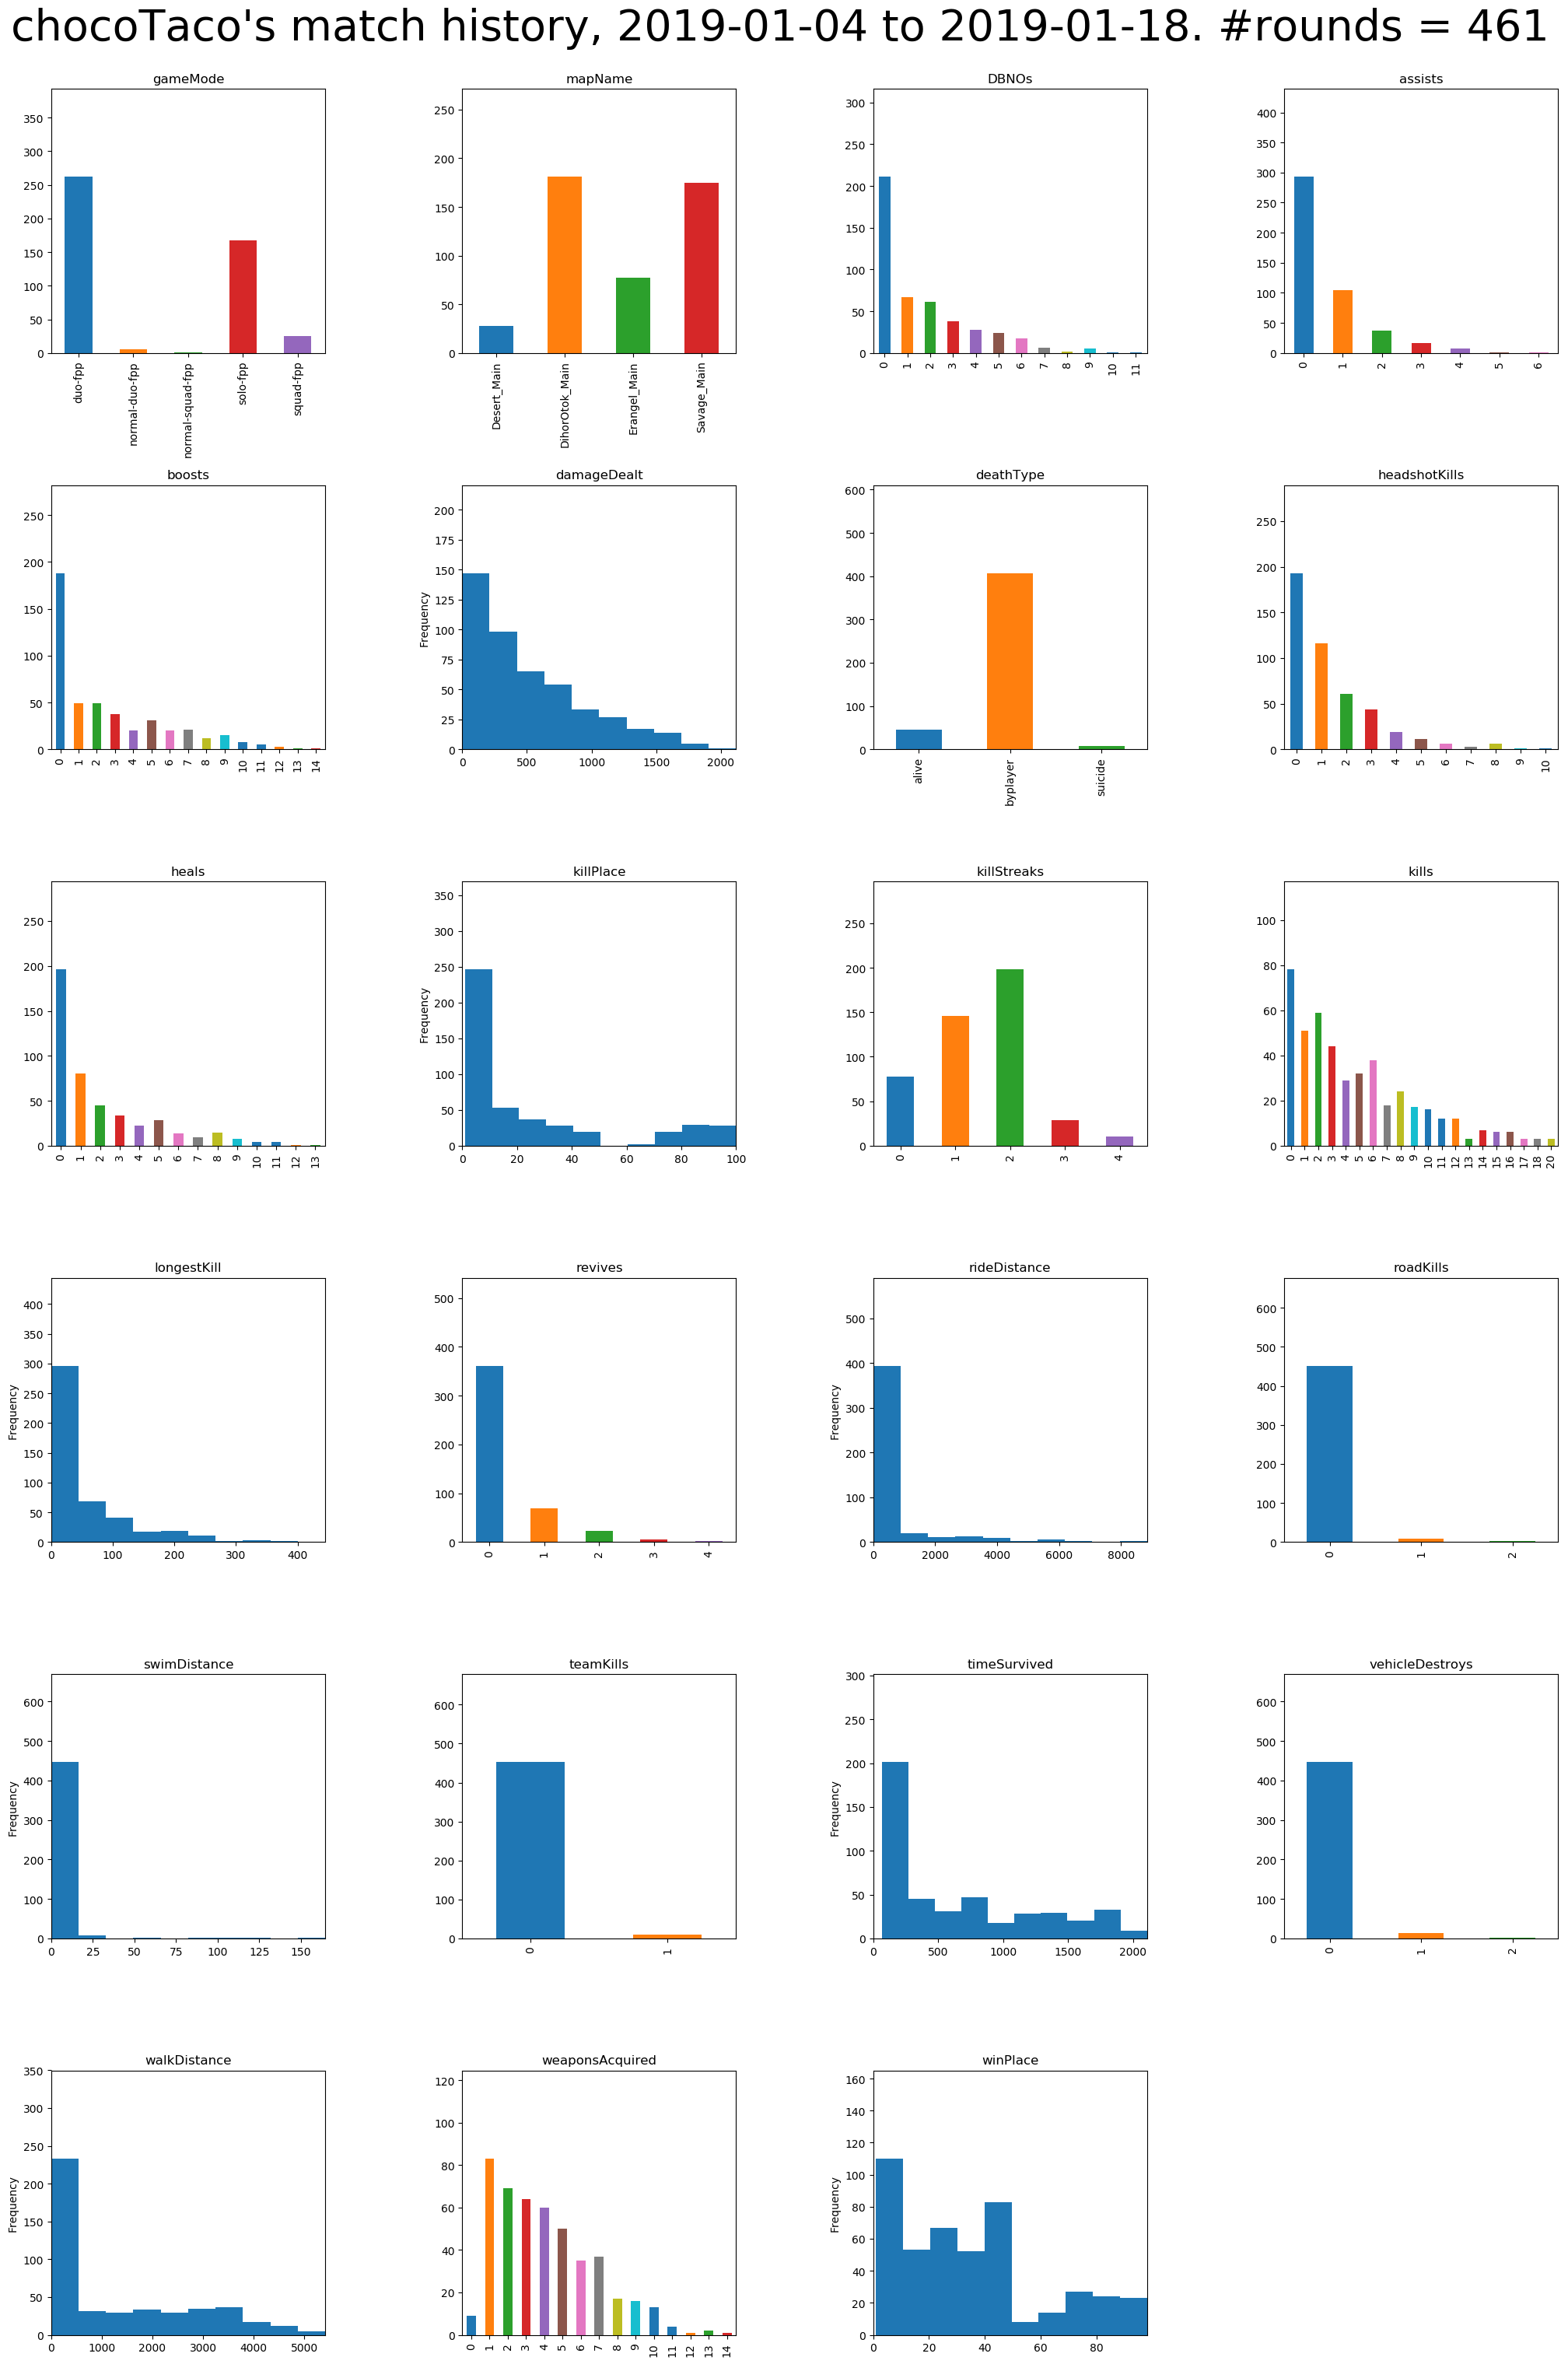

In [8]:
generate_plots(match_stats)